In [9]:
# Para importar la data
import os

# Importar para manipulacion de datos
import numpy as np
import pandas as pd
import datetime as dt
from statistics import *

# Importar para Visualizacion 
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# import warnings # para evitar warnings
# warnings.filterwarnings('ignore')
import textwrap
from textwrap import wrap
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# For NLP
from fuzzywuzzy import fuzz

# Importar Dependencias
%matplotlib inline

# **Revision de variables**

In [2]:
# loas the data
data = pd.read_csv('dbclean/covid19_VAERS-HospPfizer.csv', index_col=0, encoding='latin-1')

# remove variables
data.drop(columns=['VAX_MANU', 'DATEDIED', 'HOSPITAL'], inplace=True)

print(f'VAERS Pfizer-Hospitalized Data has\t: {data.shape[0]} observactions and {data.shape[1]} columns.')

VAER Pfizer-Hospitalized Data has	: 17786 observactions and 24 columns.


# Creating an `TEXT` column to store all the input information

In [3]:
# columns to study
cadenas = ['HISTORY','SYMPTOM_TEXT', 'LAB_DATA', 'OTHER_MEDS', 'CUR_ILL', 'ALLERGIES', 'PRIOR_VAX']

# Fill empty rows
data.fillna({x:' ' for x in cadenas}, inplace=True)

# Join all the text information
data['TEXT'] = data[cadenas].agg(" ".join, axis=1)

# drop columns that were used
data.drop(columns = cadenas, inplace=True)

In [5]:
# Fix text
data.TEXT = data.TEXT.str.lower() # lowercase
data.TEXT = data.TEXT.str.replace('[^\w\s]',' ') # remove symbols
data.TEXT = data.TEXT.str.rstrip() # remove spaces (before)
data.TEXT = data.TEXT.str.lstrip() # remove spaces (after)

/tmp/ipykernel_37948/3419534010.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data.TEXT = data.TEXT.str.replace('[^\w\s]',' ') # limpiar signos


In [6]:
# Backup1
dataset = data.copy()

In [7]:
aesis = {'infarct_myocardic' : ['myocardic','acute myocardial infarction', 'Myocardial infarction', 
                      'Silent myocardial infarction', 'acute myocardial injury',
                      'acute myocardial ischemia'], 
         'coagulopathy' : ['coagulopathy','Acquired amegakaryocytic thrombocytopenia', 
                         'Amegakaryocytic thrombocytopenia', 'Axillary vein thrombosis', 
                         'Cavernous sinus thrombosis', 'Cerebral venous thrombosis', 
                         'Deep vein thrombosis', 'Disseminated intravascular coagulation', 
                         'Embolism venous', 'Hepatic vein thrombosis',
                         'Immune thrombocytopenia', 'Intracranial venous sinus thrombosis',
                         'Mesenteric vein thrombosis', 'Portal vein thrombosis', 
                         'Pulmonary embolism', 'Pulmonary thrombosis', 'Pulmonary venous thrombosis', 
                         'Severe fever with thrombocytopenia syndrome', 'Subclavian vein thrombosis', 
                         'Thrombocytopenia', 'Thrombocytopenic purpura', 
                         'Thrombotic thrombocytopenic purpura', 'Thrombosis', 
                         'Transverse sinus thrombosis', 'Vena cava embolism', 
                         'Vena cava thrombosis', 'Venous thrombosis'],
         'anaphylactic' : ['anaphylactic ', 'Anaphylactic reaction', 'Anaphylactic shock', 
                         'Anaphylactoid reaction', 'Anaphylactoid shock'], 
         'myocarditis_pericarditis' : ['Atypical mycobacterium pericarditis', 
                          'Autoimmune myocarditis', 'Autoimmune pericarditis', 
                          'Bacterial pericarditis','Coxsackie myocarditis', 'Coxsackie pericarditis', 
                          'Cytomegalovirus myocarditis', 'Cytomegalovirus pericarditis', 
                          'Enterovirus myocarditis','Eosinophilic myocarditis', 
                          'Hypersensitivity myocarditis', 'Immune mediated myocarditis', 
                          'Myocarditis', 'Myocarditis bacterial', 'Myocarditis helminthic', 
                          'Myocarditis infectious', 'Myocarditis meningococcal', 
                          'Myocarditis mycotic', 'Myocarditis post infection',
                          'Myocarditis septic', 'Viral myocarditis','Pericarditis','Pericarditis adhesive', 'Pericarditis constrictive', 
                          'Pericarditis helminthic', 'Pericarditis infective', 
                          'Pericarditis mycoplasma', 'Pleuropericarditis', 
                          'Purulent pericarditis', 'Viral pericarditis'], 
         'epilepsy_convulsions' : ['  Atonic seizures', 'Atypical benign partial epilepsy',
                       'Autonomic seizure', 'Clonic convulsion', 'Complex partial seizures', 
                       'Convulsion in childhood', 'Convulsion', 'Convulsions local', 
                       'Epilepsy' 'Epileptic encephalopathy' 'Febrile convulsion', 
                       'Febrile infection-related epilepsy syndrome', 
                       'Generalised non-convulsive epilepsy', 'Generalised onset non-motor seizure', 
                       'Generalised tonic-clonic seizure', 'Grand mal convulsion', 
                       'Idiopathic generalised epilepsy', 'Myoclonic epilepsy', 
                       'Neonatal seizure', 'Partial seizures with secondary generalisation', 
                       'Partial seizures', 'Petit mal epilepsy', 'Seizure anoxic', 
                       'Seizure cluster', 'Seizure like phenomena', 'Seizure', 
                       'Simple partial seizures', 'Status epilepticus', 
                       'Temporal lobe epilepsy','Tonic clonic movements', 
                       'Tonic convulsion', 'Tonic posturing'],
         'covid19' : ['Asymptomatic COVID-19', 'COVID-19 pneumonia'],
         'guillain' : ['guillain', 'barre', 'guillain Barre syndrome'], 
         'polyneurapathy' : ['polyneurapathy','Demyelinating polyneuropathy'],
         'multisystem' : ['multisystem','Multisystem inflammatory syndrome',
                          'Multisystem Inflammatory Syndrome (MIS-A)'], 
         'narcolepsia' : ['Narcolepsy', 'Cataplexy'],
         'pregnancy' : ['Abortion','Aborted pregnancy', 'Abortion complete',' Abortion early', 
                       'Abortion incomplete', 'Abortion late', 'Abortion missed', 
                       'Abortion spontaneous', 'Abortion spontaneous complete', 
                       'Abortion spontaneous incomplete', 'Abortion threatened', 
                       'Congenital anomaly', 'Drug exposure during pregnancy', 
                       'Exposure during pregnancy', 'Foetal death Maternal',
                       'exposure during pregnancy' ,'Stillbirth'],
         'stroke':  ['Basal ganglia stroke', 'Brain stem stroke', 'Cerebellar stroke', 'Cerebrovascular accident', 
                       'Embolic stroke','Haemorrhagic stroke', 'Haemorrhagic transformation stroke', 
                       'Ischaemic stroke', 'Lacunar stroke', 'Perinatal stroke', 
                       'Spinal stroke', 'Thrombotic stroke', 'Vertebrobasilar stroke'],
         'transverse_myelitis':['Transverse myelitis'],
         'autoimmuned' : ['Autoimmune disorders NEC', 'Blood autoimmune disorders', 
                          'Endocrine autoimmune disorders', 'Hepatic autoimmune disorders', 
                          'Lupus erythematosus and associated conditions', 
                          'Muscular autoimmune disorders', 'Nervous system autoimmune disorders', 
                          'Rheumatoid arthritis and associated conditions', 
                          'Scleroderma and associated disorders', 'Skin autoimmune disorders NEC'],
         'adem' : ['Acute disseminated encephalomyelitis'], 
         'multipleesclerosis' : ['Multiple sclerosis', 'Multiple sclerosis relapse', 
                          'Primary progressive multiple sclerosis', 'Progressive multiple sclerosis', 
                          'Progressive relapsing multiple sclerosis', 'Relapsing multiple sclerosis', 
                          'Relapsing-remitting multiple sclerosis', 
                          'Secondary progressive multiple sclerosis', 'Tumefactive multiple sclerosis'],
         'opticneuritis' : ['Optic neuritis', 'neuritis'],
         'CIDP' : ['Chronic inflammatory demyelinating polyneuropathy'],
         'encephalitis' : ['Encephalitis'],
         'myelitis': ['Myelitis'],
         'Encephalomyelitis' : ['Encephalomyelitis', 'Leukoencephalomyelitis', 'Noninfective encephalomyeliti'],
         'meningitis' : ['Meningitis', 'Meningitis aseptic', 'Meningitis viral'],
         'encephalopathy' : ['Encephalopathy', 'Leukoencephalopathy'],
         'ataxia' : ['Ataxia', 'Cerebellar ataxia', 'Cerebral ataxia'],
         'noanaphylactic' : ['Allergic reaction to excipient', 'Allergy to vaccine', 
                             'Allergic bronchitis', 'Allergic colitis', 'Allergic cough', 
                             'Allergic cystitis', 'Allergic gastroenteritis', 
                             'Allergic hepatitis', 'Allergic keratitis', 
                             'Allergic pharyngitis', 'Allergic reaction to excipient', 
                             'Allergic respiratory disease', 'Allergic respiratory symptom', 
                             'Allergic sinusitis', 'Conjunctivitis allergic',
                             'Dermatitis allergic', 'Encephalitis allergic', 
                             'Encephalopathy allergic', 'Laryngitis allergic', 
                             'Nephritis allergic', 'Pruritus allergic', 'Rhinitis allergic']
         }

In [11]:
# NPL function
def aesisDetect(row, aesi):
  sinonimos = aesis[aesi]
  contador = 0
  for sinonimo in sinonimos:
    if fuzz.partial_ratio(row,sinonimo.lower()) > 85 :
      #print(f'{sinonimo.lower()} : en : {row}')
      contador += 1
  return contador

In [13]:
# Check every AESI term under every row in the dataframe
for aesi in aesis.keys():
  dataset[aesi] = dataset.TEXT.apply(lambda x: aesisDetect(x, aesi))

# Visualization
for aesi in aesis.keys():
  print(dataset[aesi].value_counts())

0    17439
1      299
4       20
2       17
3        9
5        2
Name: infarct_myocardic, dtype: int64
0    17379
1      325
2       65
3       17
Name: coagulopathy, dtype: int64
0    17760
3       12
2       11
1        3
Name: anaphylactic, dtype: int64
0     17383
1       375
2        16
16        7
14        3
3         2
Name: myocarditis_pericarditis, dtype: int64
0     17296
1       477
2         9
4         3
13        1
Name: epilepsy_convulsions, dtype: int64
0    17604
1      161
2       21
Name: covid19, dtype: int64
0    17696
1       45
2       27
3       18
Name: guillain, dtype: int64
0    17781
1        4
2        1
Name: polyneurapathy, dtype: int64
0    17782
1        2
2        2
Name: multisystem, dtype: int64
0    17781
1        4
2        1
Name: narcolepsia, dtype: int64
0    17778
1        8
Name: pregnancy, dtype: int64
0     17624
1       155
2         5
12        2
Name: stroke, dtype: int64
0    17763
1       23
Name: transverse_myelitis, dtype: int64
0  

In [14]:
# BACKUP 2
backup = dataset.copy()

In [15]:
# Reemplazando valores numericos a binario (tipo onehotencoding)
for i in list(aesis.keys()):
  dataset[i] = np.where(dataset[i] > 0, 1, dataset[i])

# Visualizando los valores
for aesi in aesis.keys():
  print(dataset[aesi].value_counts())

0    17439
1      347
Name: infarct_myocardic, dtype: int64
0    17379
1      407
Name: coagulopathy, dtype: int64
0    17760
1       26
Name: anaphylactic, dtype: int64
0    17383
1      403
Name: myocarditis_pericarditis, dtype: int64
0    17296
1      490
Name: epilepsy_convulsions, dtype: int64
0    17604
1      182
Name: covid19, dtype: int64
0    17696
1       90
Name: guillain, dtype: int64
0    17781
1        5
Name: polyneurapathy, dtype: int64
0    17782
1        4
Name: multisystem, dtype: int64
0    17781
1        5
Name: narcolepsia, dtype: int64
0    17778
1        8
Name: pregnancy, dtype: int64
0    17624
1      162
Name: stroke, dtype: int64
0    17763
1       23
Name: transverse_myelitis, dtype: int64
0    17784
1        2
Name: autoimmuned, dtype: int64
0    17785
1        1
Name: adem, dtype: int64
0    17742
1       44
Name: multipleesclerosis, dtype: int64
0    17781
1        5
Name: opticneuritis, dtype: int64
0    17782
1        4
Name: CIDP, dtype: int64
0    1

In [16]:
# creamos una columna con toda la informacion textual
dataset['decision'] = dataset[list(aesis.keys())].agg(np.sum, axis=1)

# Visualizando los valores
dataset.decision.value_counts()

0    15825
1     1610
2      344
3        6
4        1
Name: decision, dtype: int64

<AxesSubplot:>

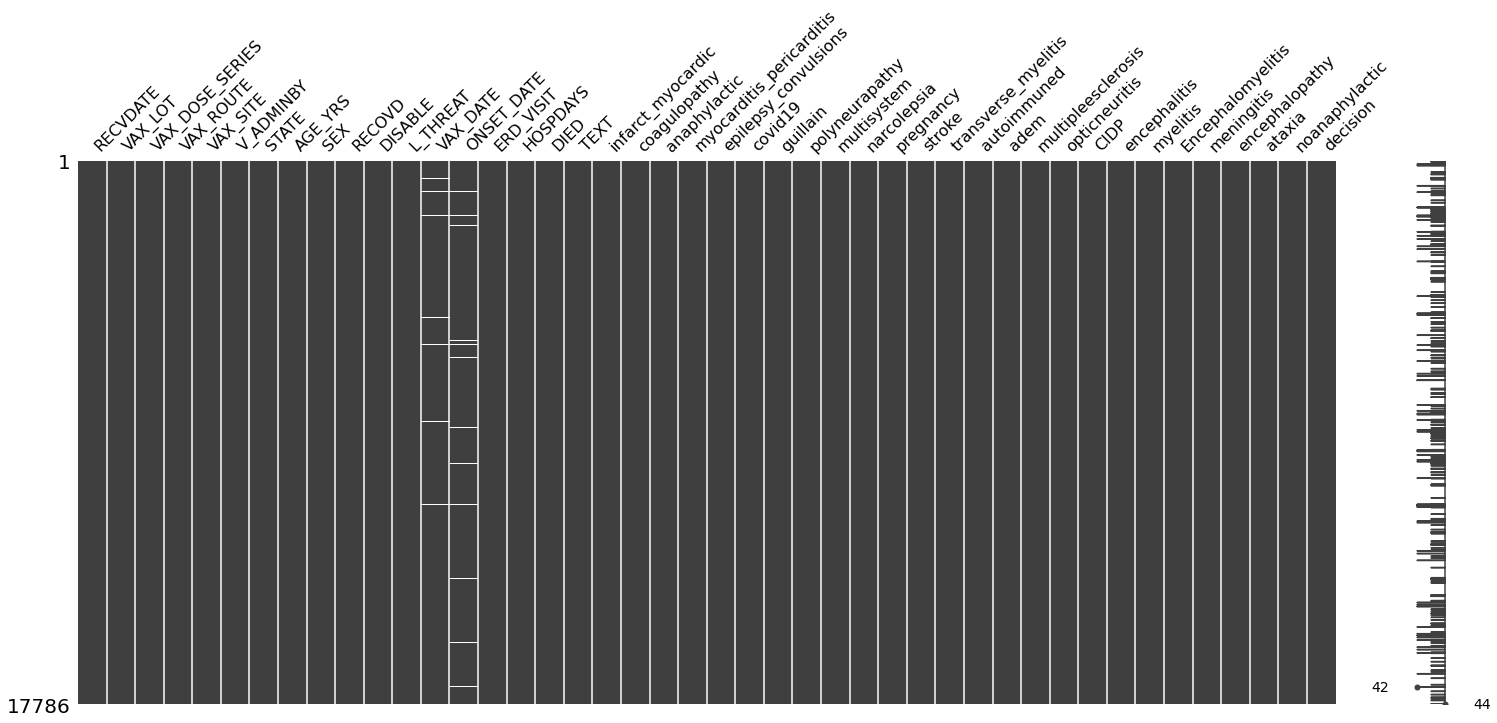

In [17]:
import missingno as msno
msno.matrix(dataset)

In [18]:
## Ultima revision
print(f'Tenemos {dataset.loc[dataset["decision"] > 0].shape[0]} observaciones y {dataset.loc[dataset["decision"] > 0].shape[1]} variables para modelar.')

Tenemos 1961 observaciones y 44 variables para modelar.


In [19]:
# seleecionams las observaciones que tienen al menos un evento aesi
dataset = dataset.loc[dataset["decision"] > 0]

In [20]:
# eliminamos variables no utiles
dataset.drop(columns=['TEXT', 'decision'], inplace=True)

In [21]:
# eliminamos fechas
dataset = dataset.dropna()
dataset['RECVDATE'] =  dataset['RECVDATE'].apply(pd.to_datetime, format='%Y-%m-%d')
dataset['VAX_DATE'] =  dataset['VAX_DATE'].apply(pd.to_datetime, format='%Y-%m-%d')
dataset['ONSET_DATE'] =  dataset['ONSET_DATE'].apply(pd.to_datetime, format='%Y-%m-%d')

In [22]:
# renombrar columna y usar mayusculas para igualar valores.
dataset.columns = dataset.columns.str.lower()
dataset.vax_lot = dataset.vax_lot.str.upper()

In [23]:
# revisando columnas especificas
dataset.columns

Index(['recvdate', 'vax_lot', 'vax_dose_series', 'vax_route', 'vax_site',
       'v_adminby', 'state', 'age_yrs', 'sex', 'recovd', 'disable', 'l_threat',
       'vax_date', 'onset_date', 'erd_visit', 'hospdays', 'died',
       'infarct_myocardic', 'coagulopathy', 'anaphylactic',
       'myocarditis_pericarditis', 'epilepsy_convulsions', 'covid19',
       'guillain', 'polyneurapathy', 'multisystem', 'narcolepsia', 'pregnancy',
       'stroke', 'transverse_myelitis', 'autoimmuned', 'adem',
       'multipleesclerosis', 'opticneuritis', 'cidp', 'encephalitis',
       'myelitis', 'encephalomyelitis', 'meningitis', 'encephalopathy',
       'ataxia', 'noanaphylactic'],
      dtype='object')

<AxesSubplot:>

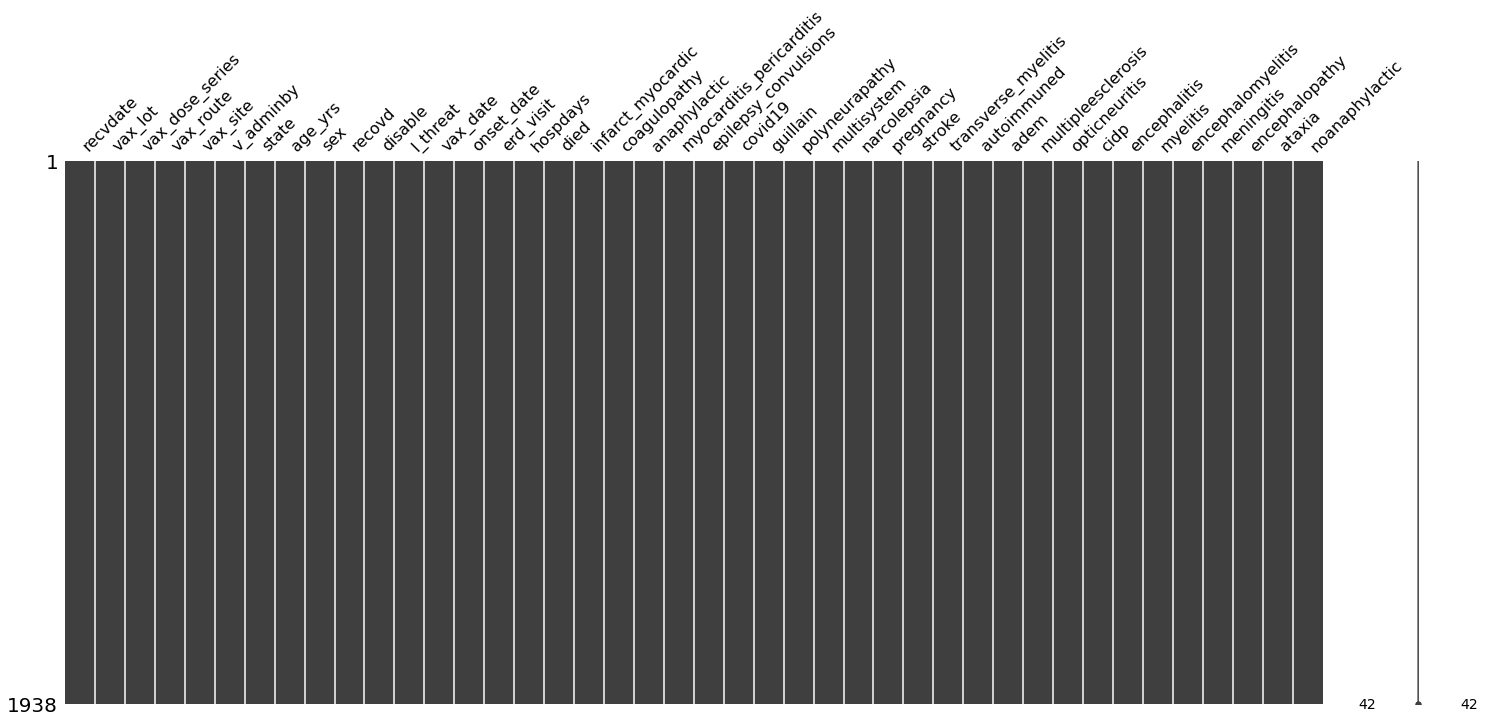

In [24]:
msno.matrix(dataset)

In [25]:
# Exportando datasets
dataset.to_csv('modelData/covi19-VAERS_Hosp_Pfizer_AESI.csv')